In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm import tqdm
import os
from importlib import reload

import nigiwai_random
reload(nigiwai_random)

<module 'nigiwai_random' from '/Users/kaji/Dropbox/maple/COI/Nigiwai_vectorfields/Nigiwai_Randomness/kaji/nigiwai_random.py'>

In [10]:
# Consgestion data
scale = 1
start_frame = 0
end_frame = 300
frame_skip = 2

#datadir = "../data/500fr_ratio_test"
datadir = "../data/300fr_spawn"

# shopping ratio test data
names = sorted(os.listdir(datadir))
df_list = [pd.read_csv(os.path.join(datadir,fn),header=0,delim_whitespace=True,dtype='f8') for fn in names]
names = [os.path.splitext(fn)[0] for fn in names]

coords = [nigiwai_random.load_vadere(df, scale, start_frame, end_frame, frame_skip) for df in df_list]


100%|██████████| 112059/112059 [00:03<00:00, 30892.02it/s]


# Nigiwai indicator

In [14]:
# parameters for indicators
fr_number = 10 # time window for computing Nigiwai
weight_r1_each = 0 # weight of R_1 in Nigiwai for individual pedestrians
weight_r1_all = 1 # weight of R_1 in Nigiwai for all pedestrians
weight_all = 0.5 # weight of Nigiwai for all pedestrians
weight_entropy = 0.5 # weight of entropy
noise_std = 0 # std of gaussian noise for the coordinate

In [15]:
def compute_indicators_graph(df_vadere, weight_r1_each, weight_r1_all, weight_all, weight_entropy, fr_number=9):
    X, Y = nigiwai_random.add_noise_to_coords(df_vadere[0],df_vadere[1],noise_std)
    u, v = nigiwai_random.compute_velocity(X,Y,noise_std)
    
    L_all = []
    # iterate over frames
    for target_fr in range(fr_number, round(end_frame/frame_skip)-1):
        L = dict()
        u_f = u[:,target_fr-fr_number:target_fr+1]
        v_f = v[:,target_fr-fr_number:target_fr+1]

        ped_mask = ~np.isnan( (u_f.sum(axis=1)+v_f.sum(axis=1)) )
        u_f = u_f[ped_mask]
        v_f = v_f[ped_mask]

        all_mask = ~np.isnan( u[:,target_fr]+v[:,target_fr] )
        u_g = u[all_mask,target_fr].reshape(1,-1)
        v_g = v[all_mask,target_fr].reshape(1,-1)        
        
        # indicators
        if len(u_f)>0:
            L['r1_each'] = nigiwai_random.compute_moment(u_f,v_f,1)
            L['r2_each'] = nigiwai_random.compute_moment(u_f,v_f,2)
            L['nig_each'] = np.maximum(1 - (weight_r1_each*L['r1_each'] + (1-weight_r1_each)*L['r2_each']),0)
            L['nig_ent'] =  nigiwai_random.entropy_base(u_f,v_f)
            L['nig_each_weighted'] = (L['nig_ent'] ** weight_entropy) * (L['nig_each'] ** (1-weight_entropy))
            L['nig_each_weighted_mean'] = L['nig_each_weighted'].mean()
            L['nig_each_mean'] = L['nig_each'].mean()
        else:
            L['nig_each_mean'] = np.zeros(1)
            L['nig_each_weighted_mean'] = np.zeros(1)
            L['nig_ent'] = np.zeros(1)

        if len(u_g)>0:
            L['r1_all'] = nigiwai_random.compute_moment(u_g,v_g,1)
            L['r2_all'] = nigiwai_random.compute_moment(u_g,v_g,2)
            L['nig_all'] = np.maximum(1 - (weight_r1_all*L['r1_all']   + (1-weight_r1_all)*L['r2_all']),0)
        else:
            L['nig_all'] = np.zeros(1)

        # aggregated indicators
        L['nig'] = (L['nig_all']**weight_all) * ( L['nig_each_weighted_mean'] **(1-weight_all))
        
        L_all.append(L)

    L_res = dict()
    for k in ['nig_each_mean','nig_ent','nig_all','nig']:
        L_res[k] = nigiwai_random.moving_average([L[k].mean() for L in L_all], alpha=0.8)
    return(L_res)



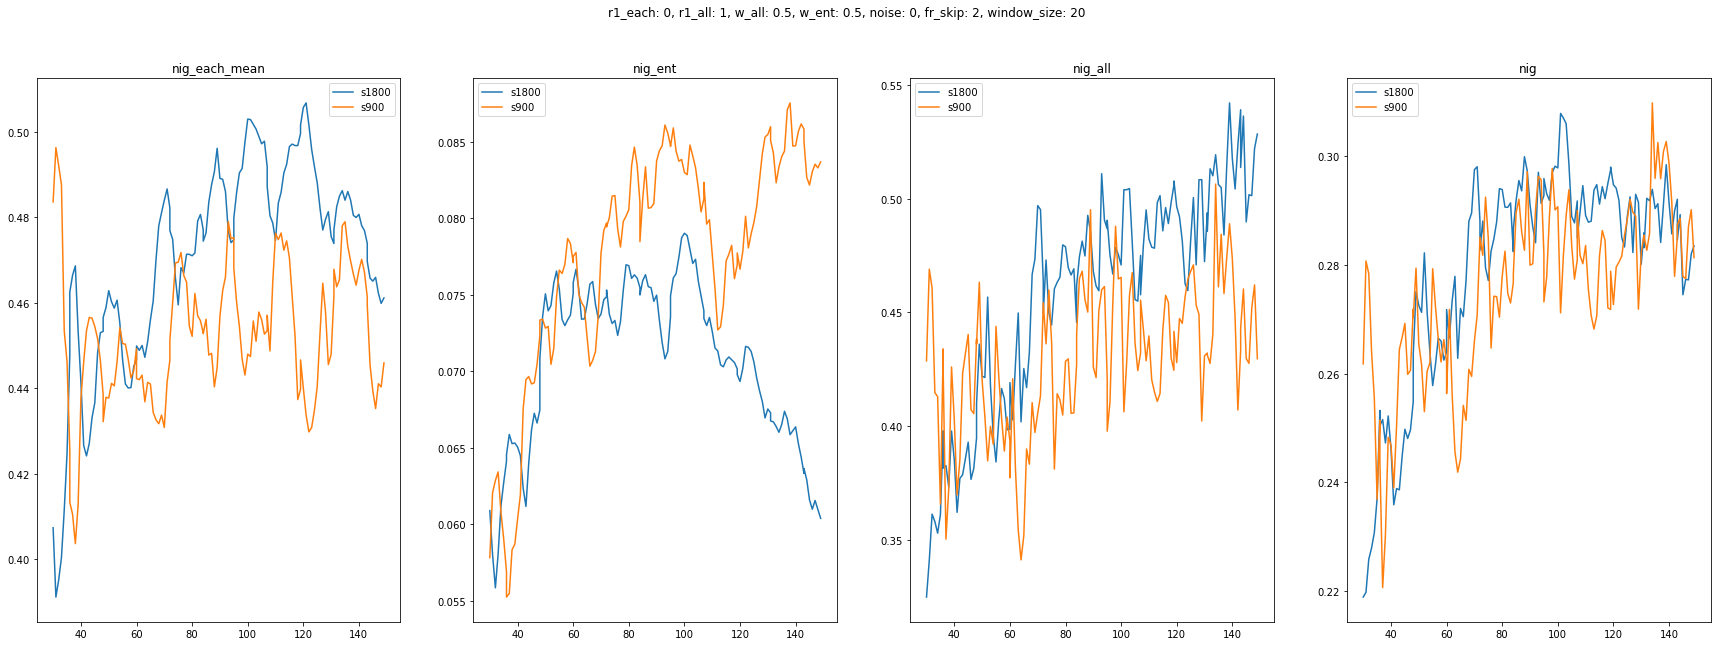

In [17]:

fig,ax = plt.subplots(1,4,figsize=(30, 10))
fig.suptitle(f'r1_each: {weight_r1_each}, r1_all: {weight_r1_all}, w_all: {weight_all}, w_ent: {weight_entropy}, noise: {noise_std}, fr_skip: {frame_skip}, window_size: {fr_number}')
st = 10
for i,df_vadere in enumerate(coords):
    L_res = compute_indicators_graph(df_vadere, weight_r1_each, weight_r1_all, weight_all, weight_entropy, fr_number=9)
    for j,k in enumerate(L_res.keys()):
        ax[j].plot(np.round(np.linspace(fr_number+st, end_frame/frame_skip-1,len(L_res[k][st:]))), L_res[k][st:], label=names[i])
        ax[j].set_title(k)
        ax[j].legend()
plt.show()